# RNN

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import seaborn as sns
import re
import pandas as pd
from collections import Counter
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras import layers

https://www.kaggle.com/datasets/deepcontractor/200k-short-texts-for-humor-detection

In [ ]:
df = pd.read_csv('Humour.csv', engine='python')
df

,text,humor
0,"Joe biden rules out 2020 bid: 'guys, i'm not r...",False
1,Watch: darvish gave hitter whiplash with slow ...,False
2,What do you call a turtle without its shell? d...,True
3,5 reasons the 2016 election feels so personal,False
4,"Pasco police shot mexican migrant from behind,...",False
...,...,...
199995,Conor maynard seamlessly fits old-school r&b h...,False
199996,How to you make holy water? you boil the hell ...,True
199997,How many optometrists does it take to screw in...,True
199998,Mcdonald's will officially kick off all-day br...,False


In [ ]:
df["humor"] = df["humor"].astype(int)
df

,text,humor
0,"Joe biden rules out 2020 bid: 'guys, i'm not r...",0
1,Watch: darvish gave hitter whiplash with slow ...,0
2,What do you call a turtle without its shell? d...,1
3,5 reasons the 2016 election feels so personal,0
4,"Pasco police shot mexican migrant from behind,...",0
...,...,...
199995,Conor maynard seamlessly fits old-school r&b h...,0
199996,How to you make holy water? you boil the hell ...,1
199997,How many optometrists does it take to screw in...,1
199998,Mcdonald's will officially kick off all-day br...,0


In [ ]:
BOW = []
text_lengths = []
for id, row in tqdm(df.iterrows()):
  clear = re.findall('[a-z]+', row['text'].lower())
  text_lengths.append(len(clear))
  BOW.extend((clear))
  df.at[id, 'text'] = ' '.join(clear)
BOW = Counter(BOW)

len(BOW), np.median(text_lengths, axis=0), np.mean(text_lengths, axis=0)

<ipython-input-4-388a9dd7820b>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for id, row in tqdm(df.iterrows()):


0it [00:00, ?it/s]

(59852, 12.0, 12.296985)

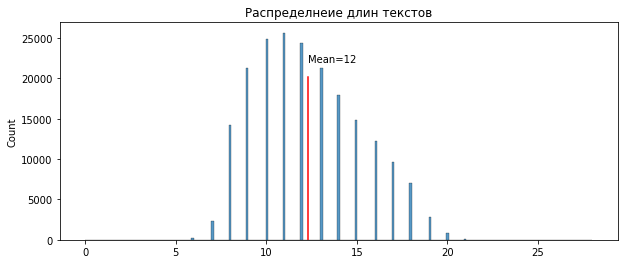

In [ ]:
plt.figure(figsize=(10, 4))
sns.histplot(text_lengths)
plt.title('Распределнеие длин текстов')
plt.axvline(x=np.mean(text_lengths), ymin=0, ymax=0.75, color='r')
plt.text(np.mean(text_lengths), 22000, f'Mean={int(np.mean(text_lengths))}')
plt.show()

In [ ]:
BOW = {word[0]: ind + 1 for ind, word in enumerate(BOW.most_common())}

In [ ]:
pad_length = 20

def padding(sequence):
  while len(sequence) < pad_length:
    sequence.append(0)
  if len(sequence) > pad_length:
    sequence = sequence[:pad_length]
  return sequence

In [ ]:
def encode_text(text):
  words = text.lower().split()
  row_encoded = []
  for word in words:
    try:
      row_encoded.append(BOW[word])
    except KeyError:
      row_encoded.append(len(BOW.keys()))
  row_encoded = np.array(padding(row_encoded))
  return row_encoded

In [ ]:
df['enc'] = np.nan
df['enc'] = df['enc'].astype('object')

for i, row in tqdm(df.iterrows()):

  encode = encode_text(row['text'])
  df.at[i, 'enc'] = encode

df

<ipython-input-9-bc4aec569e04>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, row in tqdm(df.iterrows()):


0it [00:00, ?it/s]

,text,humor,enc
0,joe biden rules out bid guys i m not running,0,"[916, 1705, 774, 45, 3859, 288, 6, 56, 48, 534..."
1,watch darvish gave hitter whiplash with slow p...,0,"[191, 34135, 640, 10397, 20199, 18, 1158, 3309..."
2,what do you call a turtle without its shell dead,1,"[9, 14, 5, 34, 2, 3173, 259, 154, 3860, 195, 0..."
3,reasons the election feels so personal,0,"[474, 1, 353, 1743, 50, 1324, 0, 0, 0, 0, 0, 0..."
4,pasco police shot mexican migrant from behind ...,0,"[34136, 201, 520, 351, 5764, 41, 436, 47, 7184..."
...,...,...,...
199995,conor maynard seamlessly fits old school r b h...,0,"[10043, 15087, 22841, 4451, 128, 196, 459, 626..."
199996,how to you make holy water you boil the hell o...,1,"[20, 3, 5, 68, 1564, 294, 5, 5250, 1, 642, 45,..."
199997,how many optometrists does it take to screw in...,1,"[20, 142, 13212, 58, 12, 99, 3, 1046, 7, 2, 85..."
199998,mcdonald s will officially kick off all day br...,0,"[1613, 4, 73, 2392, 1440, 91, 59, 76, 993, 16,..."


##Simple RNN

In [ ]:
data = np.array(df['enc'].to_list())
labels = np.array(df['humor'].to_list())
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, stratify=labels)

In [ ]:
embedding_size = 16

model = tf.keras.Sequential()
model.add(layers.Embedding(input_dim=len(BOW) + 2, output_dim=embedding_size)) 
model.add(layers.SimpleRNN(32, return_sequences=True))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dropout(0.3))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(1, activation = 'sigmoid'))
model.compile(loss='BinaryCrossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          957664    
                                                                 
 simple_rnn (SimpleRNN)      (None, None, 32)          1568      
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                        

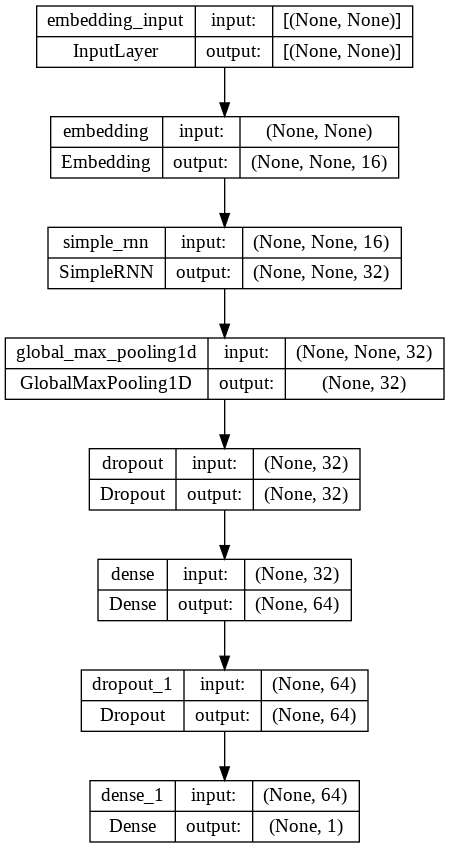

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
history = model.fit(X_train, y_train, epochs=5, batch_size=256)

Epoch 1/5
625/625 [==============================] - 15s 22ms/step - loss: 0.2230 - accuracy: 0.9157
Epoch 2/5
625/625 [==============================] - 13s 21ms/step - loss: 0.1224 - accuracy: 0.9562
Epoch 3/5
625/625 [==============================] - 13s 21ms/step - loss: 0.0891 - accuracy: 0.9686
Epoch 4/5
625/625 [==============================] - 14s 23ms/step - loss: 0.0683 - accuracy: 0.9761
Epoch 5/5
625/625 [==============================] - 15s 24ms/step - loss: 0.0545 - accuracy: 0.9809


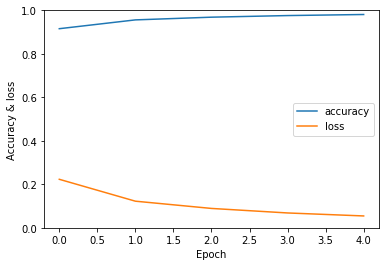

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['loss'], label = 'loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy & loss')
plt.ylim([0.0, 1])
plt.legend(loc='right')
plt.show()

In [ ]:
pred_y = model.predict(X_test, verbose=1)
prediction = [1 if i >= .5 else 0 for i in pred_y]

1250/1250 [==============================] - 3s 3ms/step


In [ ]:
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.92      0.96      0.94     20000
           1       0.96      0.91      0.94     20000

    accuracy                           0.94     40000
   macro avg       0.94      0.94      0.94     40000
weighted avg       0.94      0.94      0.94     40000



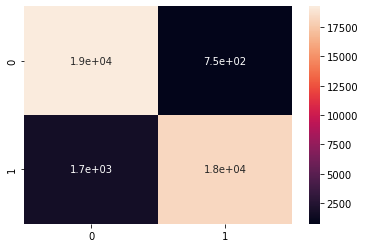

In [ ]:
sns.heatmap(confusion_matrix(y_test, prediction), annot=True)

##LSTM with validation

In [ ]:
# .64 train, .16 validation, .2 test
X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train)

In [ ]:
model = tf.keras.Sequential()
model.add(layers.Embedding(input_dim=len(BOW) + 2, output_dim=embedding_size)) 
model.add(layers.LSTM(32, return_sequences=True))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dropout(0.3))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(1, activation = 'sigmoid'))
model.compile(loss='BinaryCrossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 16)          957664    
                                                                 
 lstm (LSTM)                 (None, None, 32)          6272      
                                                                 
 global_max_pooling1d_1 (Glo  (None, 32)               0         
 balMaxPooling1D)                                                
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 64)                2112      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                      

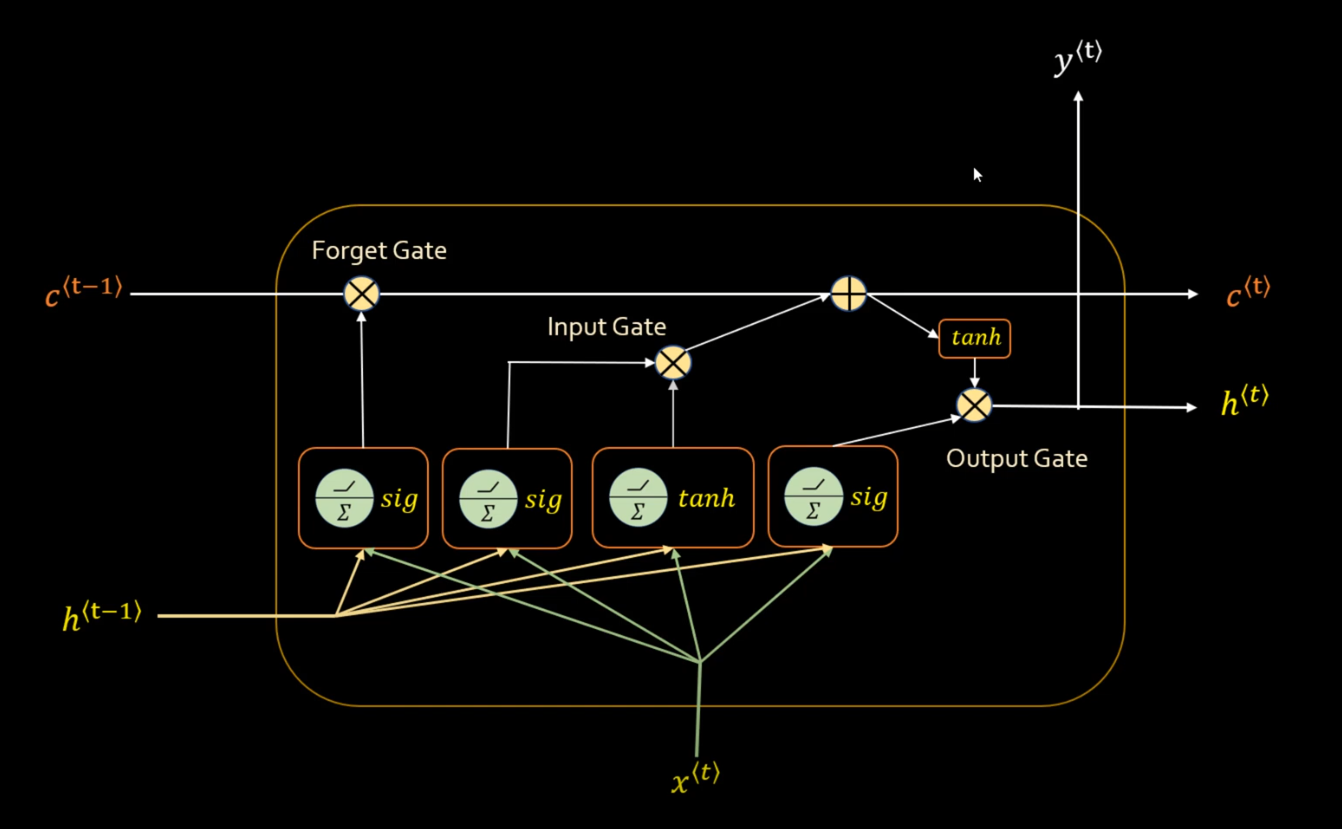

In [ ]:
class haltCallback(tf.keras.callbacks.Callback):
  def __init__(self, patience=3):
    self.best_difference = None
    self.streak = 0
    self.patience = patience


  def on_epoch_end(self, epoch, logs={}):

    train_loss = logs.get('loss')
    valid_loss = logs.get('val_loss')
    epoch_difference = valid_loss - train_loss
      
    if self.best_difference == None:
      self.best_difference = epoch_difference
      return

    if self.best_difference > epoch_difference:
      self.best_difference = epoch_difference
    else:
      self.streak += 1

    if self.best_difference <= 10 ** -3 or \
      valid_loss < train_loss:
      self.streak += 1

    
    if self.streak >= self.patience:
      self.model.stop_training = True


In [ ]:
history = model.fit(X_train, y_train, epochs=10, batch_size=256, validation_data = [X_val, y_val], callbacks=[haltCallback()])
# model.fit(X_train, y_train, epochs=10, batch_size=256, validation_split=.2)

Epoch 1/10
500/500 [==============================] - 20s 37ms/step - loss: 0.2391 - accuracy: 0.8996 - val_loss: 0.1612 - val_accuracy: 0.9384
Epoch 2/10
500/500 [==============================] - 18s 35ms/step - loss: 0.1291 - accuracy: 0.9521 - val_loss: 0.1581 - val_accuracy: 0.9398
Epoch 3/10
500/500 [==============================] - 18s 35ms/step - loss: 0.1036 - accuracy: 0.9618 - val_loss: 0.1648 - val_accuracy: 0.9389


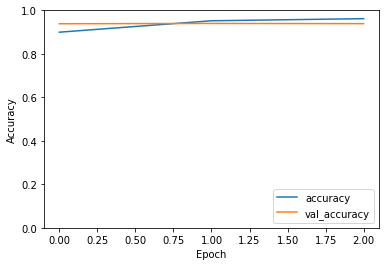

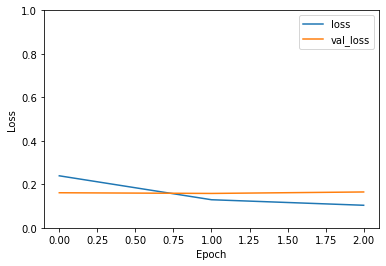

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.0, 1])
plt.legend(loc='lower right')
plt.show()
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0.0, 1])
plt.legend(loc='upper right')
plt.show()

In [ ]:
pred_y = model.predict(X_test, verbose=1)
prediction = [1 if i >= .5 else 0 for i in pred_y]

1250/1250 [==============================] - 5s 4ms/step


In [ ]:
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94     20000
           1       0.94      0.94      0.94     20000

    accuracy                           0.94     40000
   macro avg       0.94      0.94      0.94     40000
weighted avg       0.94      0.94      0.94     40000



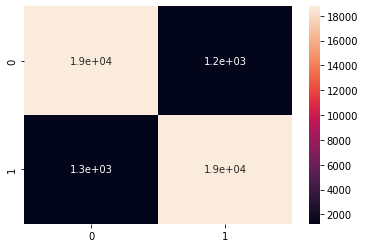

In [ ]:
sns.heatmap(confusion_matrix(y_test, prediction), annot=True)

## GRU + DATA GEN

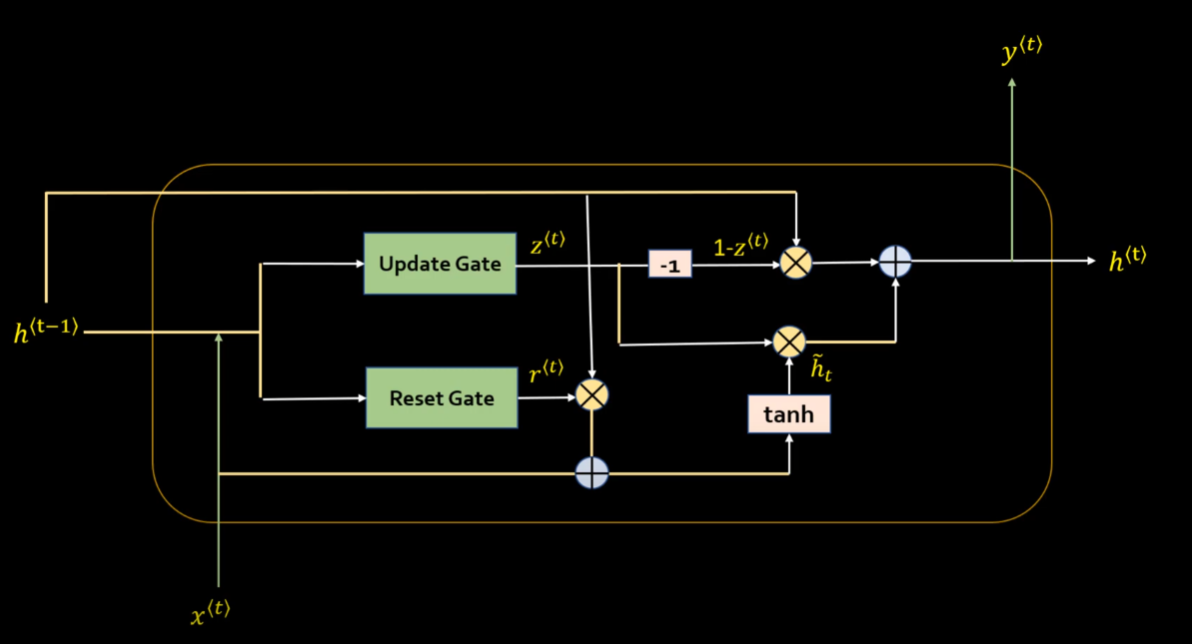

In [ ]:
model = tf.keras.Sequential()
model.add(layers.Embedding(input_dim=len(BOW) + 2, output_dim=embedding_size)) 
model.add(layers.GRU(32, return_sequences=True))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dropout(0.3))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(1, activation = 'sigmoid'))
model.compile(loss='BinaryCrossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 16)          957664    
                                                                 
 gru (GRU)                   (None, None, 32)          4800      
                                                                 
 global_max_pooling1d_2 (Glo  (None, 32)               0         
 balMaxPooling1D)                                                
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 dense_4 (Dense)             (None, 64)                2112      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                      

In [ ]:
df = df.drop('enc', axis=1)
data_train, data_test = train_test_split(df, test_size=0.2, random_state=42)
data_train, data_val = train_test_split(data_train, test_size=0.2, random_state=42)
df

,text,humor
0,joe biden rules out bid guys i m not running,0
1,watch darvish gave hitter whiplash with slow p...,0
2,what do you call a turtle without its shell dead,1
3,reasons the election feels so personal,0
4,pasco police shot mexican migrant from behind ...,0
...,...,...
199995,conor maynard seamlessly fits old school r b h...,0
199996,how to you make holy water you boil the hell o...,1
199997,how many optometrists does it take to screw in...,1
199998,mcdonald s will officially kick off all day br...,0


In [ ]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, 
              batch_size=256, 
              shuffle=True):
        self.df = df.copy()
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

        self.texts = self.df['text'].values
        self.labels = self.df['humor'].values
    
    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))
    
    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        
        X = []
        for text in self.texts[indexes]:
                X.append(encode_text(text))
        y = self.labels[indexes]
        X = np.array(X)
        
        return X, y
        
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.df))
        if self.shuffle:
            np.random.shuffle(self.indexes)

In [ ]:
train_gen = DataGenerator(data_train)
val_gen = DataGenerator(data_val)

In [ ]:
tf.config.run_functions_eagerly(True)
history = model.fit_generator(train_gen, epochs=10, validation_data = val_gen, callbacks=[haltCallback()])

Epoch 1/10


<ipython-input-30-68cec851983e>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen, epochs=10, validation_data = val_gen, callbacks=[haltCallback()])
/usr/local/lib/python3.8/dist-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


500/500 [==============================] - 68s 135ms/step - loss: 0.2510 - accuracy: 0.9028 - val_loss: 0.1577 - val_accuracy: 0.9388
Epoch 2/10
500/500 [==============================] - 72s 145ms/step - loss: 0.1330 - accuracy: 0.9510 - val_loss: 0.1540 - val_accuracy: 0.9415
Epoch 3/10
500/500 [==============================] - 67s 135ms/step - loss: 0.1041 - accuracy: 0.9626 - val_loss: 0.1598 - val_accuracy: 0.9414


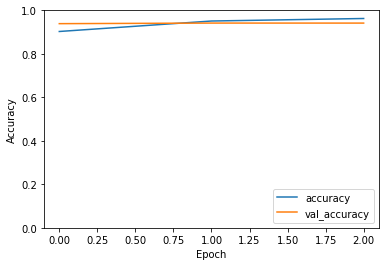

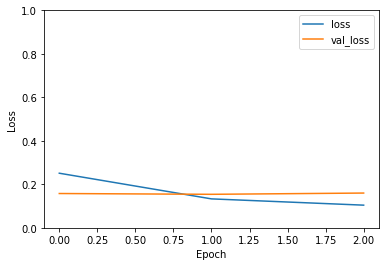

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.0, 1])
plt.legend(loc='lower right')
plt.show()
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0.0, 1])
plt.legend(loc='upper right')
plt.show()

In [ ]:
test_gen = DataGenerator(data_test, batch_size=1, shuffle=False)
vectors_test = []
labels_test = []
for i in tqdm(range(len(data_test))):
    data, label = test_gen[i]
    vectors_test.append(data)
    labels_test.append(label)
vectors_test = np.array(vectors_test)[:,0]
labels_test = np.array(labels_test)[:,0]
vectors_test.shape

<ipython-input-32-605666cc2818>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(data_test))):


  0%|          | 0/40000 [00:00<?, ?it/s]

(40000, 20)

In [ ]:
def get_predictions(data_test):
    test_pred = model.predict(data_test)
    test_pred = [1 if i >= .5 else 0 for i in test_pred]
    return test_pred

In [ ]:
test_pred = get_predictions(vectors_test)

1250/1250 [==============================] - 45s 36ms/step


In [ ]:
print(classification_report(labels_test, test_pred))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94     20001
           1       0.94      0.94      0.94     19999

    accuracy                           0.94     40000
   macro avg       0.94      0.94      0.94     40000
weighted avg       0.94      0.94      0.94     40000



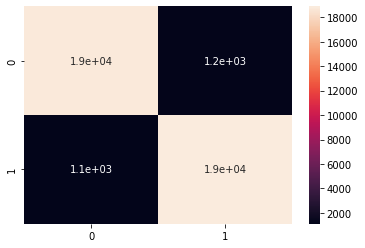

In [ ]:
sns.heatmap(confusion_matrix(labels_test, test_pred), annot=True)